In [51]:
from google.colab import drive

In [52]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [53]:
from google.colab import drive

In [54]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [55]:
import os
import re
import gc 
from tqdm import tqdm
from datetime import date     #calculating age
from datetime import datetime #converting string to date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import GridSearchCV , train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , f1_score , make_scorer
from sklearn.preprocessing import StandardScaler,OneHotEncoder , LabelEncoder ,normalize

In [56]:
df1 = pd.read_csv("/content/drive/MyDrive/Python/Logistic Regression/train.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Python/Logistic Regression/test_bqCt9Pv.csv")

In [57]:
df1.isnull().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

In [58]:
df1['Employment.Type'].value_counts()

Self employed    127635
Salaried          97858
Name: Employment.Type, dtype: int64

In [59]:
df1 = df1.fillna(df1.mode().iloc[0])
df2 = df2.fillna(df2.mode().iloc[0])

In [60]:
df1.shape

(233154, 41)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24fbfd4550>,
      dtype=object)

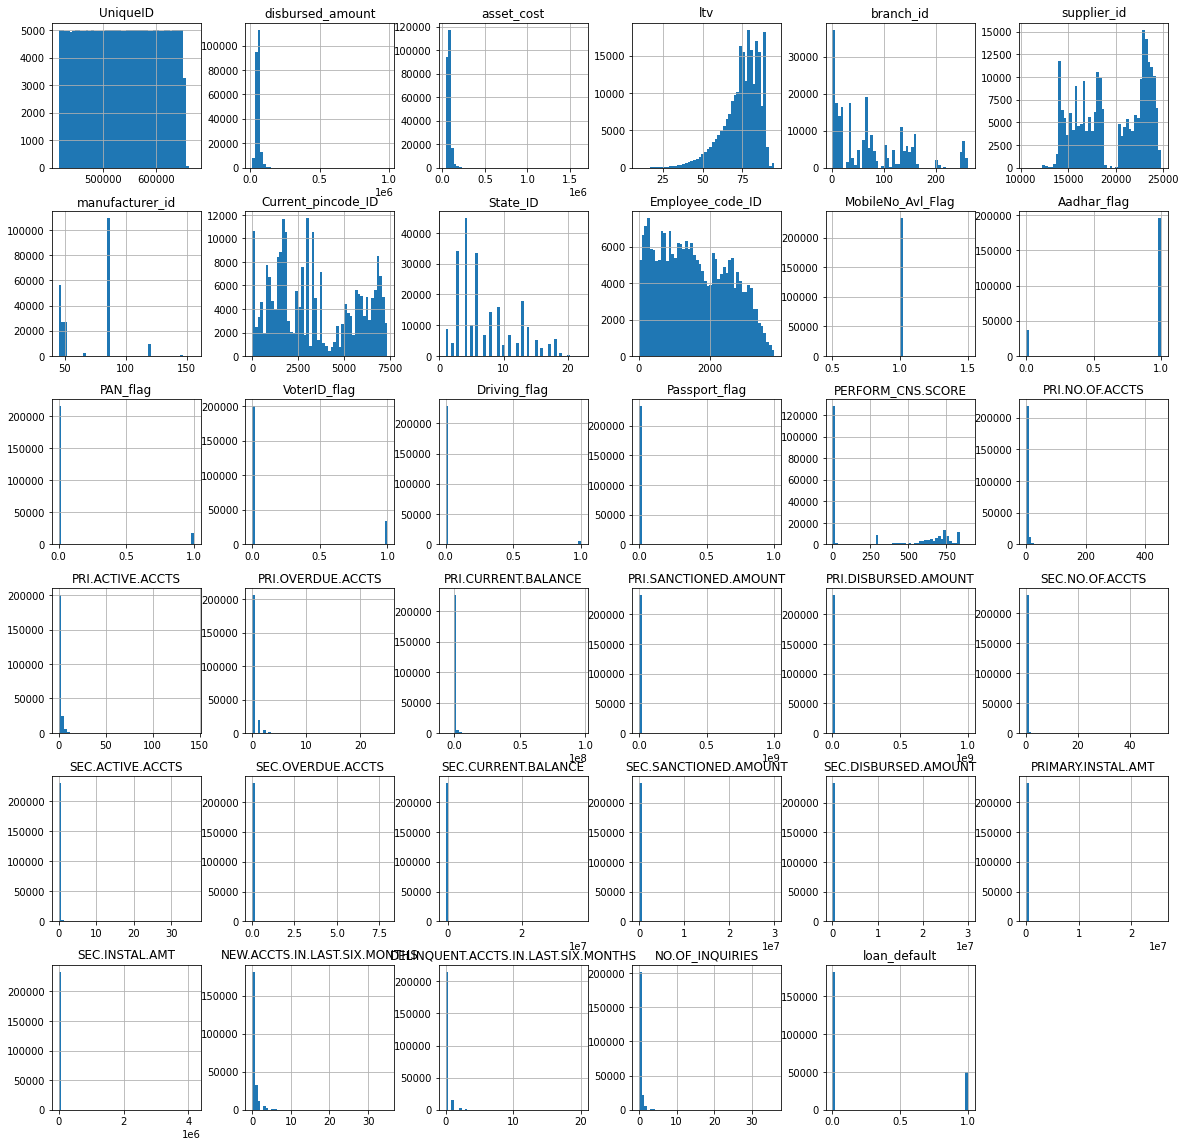

In [61]:
df1.hist(bins=50,figsize=(20,20))

In [62]:
# Checking on Categorical data
for col in tqdm(df1.columns):
    if df1[col].dtype == 'object':
        print(col , ":", df1[col].nunique())

100%|██████████| 41/41 [00:00<00:00, 426.95it/s]

Date.of.Birth : 15433
Employment.Type : 2
DisbursalDate : 84
PERFORM_CNS.SCORE.DESCRIPTION : 20
AVERAGE.ACCT.AGE : 192
CREDIT.HISTORY.LENGTH : 294


In [63]:
# CODE FOR AGE CONVERSION: https://www.geeksforgeeks.org/python-program-to-calculate-age-in-year/
def calcAge(born):
    born = datetime.strptime(born , '%d-%m-%y')
    today= date.today()
    age = today.year- born.year - ((today.month,today.day) < (born.month,born.day))
    return age

In [64]:
#df1.drop(['DisbursalDate' , 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH'], inplace=True , axis=1)
#df2.drop(['DisbursalDate' , 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH'], inplace=True , axis=1)

df1['PERFORM_CNS.SCORE.DESCRIPTION'].replace(to_replace=['Not Scored: More than 50 active Accounts found', 
                                                         'Not Scored: No Activity seen on the customer (Inactive)',
                                                         'Not Scored: No Updates available in last 36 months',
                                                         'Not Enough Info available on the customer','Not Scored: Only a Guarantor',
                                                         'Not Scored: Sufficient History Not Available',
                                                         'Not Scored: Not Enough Info available on the customer'], 
                                                   value= 'Not Scored', inplace = True)
df2['PERFORM_CNS.SCORE.DESCRIPTION'].replace(to_replace=['Not Scored: More than 50 active Accounts found', 
                                                         'Not Scored: No Activity seen on the customer (Inactive)',
                                                         'Not Scored: No Updates available in last 36 months',
                                                         'Not Enough Info available on the customer','Not Scored: Only a Guarantor',
                                                         'Not Scored: Sufficient History Not Available',
                                                         'Not Scored: Not Enough Info available on the customer'], 
                                                   value= 'Not Scored', inplace = True)

dob = df1['Date.of.Birth']
df1['Age'] = dob.map(calcAge)
df1.drop(['Date.of.Birth'] , axis=1 , inplace=True)
df1.head()

dob = df2['Date.of.Birth']
df2['Age'] = dob.map(calcAge)
df2.drop(['Date.of.Birth'] , axis=1 , inplace=True)


In [65]:
df1.shape

(233154, 41)

In [66]:
def removeOutlier(df, cols):
    indexes=[]
    for col in tqdm(cols):
        if (df[col].dtypes !='object'):
            Q1 = df[col].quantile(q=0.001)
            Q3 = df[col].quantile(q=0.999)        
            for i in (df.index):
                if ((df.loc[i,col]< Q1/5) or (df.loc[i,col] > 5*Q3)):
                    df = df.drop(index=i)
                    indexes.append(i)
    return df, indexes

In [67]:
cols_with_outliers=['disbursed_amount', 'asset_cost', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT','PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS','SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES','Employment.Type', 'PERFORM_CNS.SCORE.DESCRIPTION']

new_df1, indexex = removeOutlier(df1 , cols_with_outliers)
new_df2, indexex2 = removeOutlier(df2 , cols_with_outliers)

100%|██████████| 21/21 [00:59<00:00,  2.85s/it]


In [69]:
df1.shape

(233154, 41)

In [70]:
cat_data= df1.select_dtypes(include='object').columns
#6
df = pd.get_dummies(new_df1[cat_data])
dff = pd.get_dummies(new_df2[cat_data])
print("The shape of dummy variables : " , df.shape)
print("The shape of dummy variables : " , dff.shape)

The shape of dummy variables :  (232669, 585)
The shape of dummy variables :  (112146, 469)


In [ ]:
num_data = list(new_df1._get_numeric_data().columns)
num_data.remove('loan_default')
scaler = StandardScaler()
scaler.fit(new_df1[num_data])
normalized = scaler.transform(new_df1[num_data])
normalized2 = scaler.transform(new_df2[num_data])
normalized = pd.DataFrame(normalized , columns=num_data)
normalized2 = pd.DataFrame(normalized2 , columns=num_data)
print("The shape of normalised numerical data : " , normalized.shape)
print("The shape of normalised numerical data : " , normalized2.shape)

The shape of normalised numerical data :  (232669, 35)
The shape of normalised numerical data :  (112146, 35)


In [71]:
final_df = pd.concat([normalized , df], sort=True , axis=1)
test_df = pd.concat([normalized2 , dff], sort=True , axis=1)
final_df= final_df.dropna(axis=0)
test_df = test_df.dropna(axis=0)
final_df.info()
print("The shape of the final data:" , final_df.shape)
print("The shape of the final data:" , test_df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232184 entries, 0 to 232668
Columns: 620 entries, UniqueID to CREDIT.HISTORY.LENGTH_9yrs 9mon
dtypes: float64(620)
memory usage: 1.1 GB
The shape of the final data: (232184, 620)
The shape of the final data: (111900, 504)


In [72]:
# Finding Correlation between features
def correlation(df ,column):
    column = column.iloc[df.index]
    dff= df.join(column)
    corr_max = dff.corr()  #create correlation matrix
    top_15 = corr_max.nlargest(20 , 'loan_default')['loan_default'].index # select top 15 correlate features
    corr = np.corrcoef(dff[top_15].values.T)    
    return corr , top_15

#Plot correlation map
def plot_heatmap(corr,top_15):
    plt.figure(figsize=(15,10))
    sns.heatmap(corr, cbar=True , annot=True , fmt='.2f', yticklabels=top_15.values , xticklabels=top_15.values)
    plt.title('CORRELATION MATRIX')
    plt.show()

In [73]:
corr , top_15 = correlation(final_df, df1['loan_default'])
print("The top 15 feature correlated to target variable", top_15)

The top 15 feature correlated to target variable Index(['loan_default', 'PERFORM_CNS.SCORE.DESCRIPTION_M-Very High Risk',
       'DisbursalDate_31-10-18', 'AVERAGE.ACCT.AGE_0yrs 0mon',
       'CREDIT.HISTORY.LENGTH_0yrs 0mon',
       'PERFORM_CNS.SCORE.DESCRIPTION_No Bureau History Available',
       'PERFORM_CNS.SCORE.DESCRIPTION_K-High Risk',
       'Employment.Type_Self employed',
       'PERFORM_CNS.SCORE.DESCRIPTION_I-Medium Risk', 'Employee_code_ID',
       'State_ID', 'DisbursalDate_26-10-18', 'branch_id',
       'DisbursalDate_30-10-18', 'DisbursalDate_29-10-18',
       'DisbursalDate_10-08-18', 'VoterID_flag', 'DisbursalDate_25-10-18',
       'supplier_id', 'PERFORM_CNS.SCORE.DESCRIPTION_L-Very High Risk'],
      dtype='object')


In [75]:
X = final_df
y = new_df1['loan_default'].iloc[final_df.index]
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size=0.3 , random_state=0)
c= [0.001 ,0.0001,0.01,1,10]

In [76]:
scores=[]
for i in (c):
    lr = LogisticRegression(penalty='l1' , solver='liblinear' , max_iter=1000 , C=i)
    top15= list(top_15)
    top15.remove('loan_default')
    lr.fit(X_train[top15],y_train)
    scores.append(lr.score(X_test[top15],y_test))
print("The score for C= {} is {}".format(scores.index(max(scores)),max(scores)))

The score for C= 0 is 0.7811387389456759


In [77]:
model = LogisticRegression(penalty='l2' , solver='lbfgs' , C=1 ,max_iter=1000 )
model.fit(X,y)
predictions = model.predict(test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- AVERAGE.ACCT.AGE_12yrs 8mon
- AVERAGE.ACCT.AGE_13yrs 9mon
- AVERAGE.ACCT.AGE_14yrs 4mon
- AVERAGE.ACCT.AGE_14yrs 9mon
- AVERAGE.ACCT.AGE_15yrs 1mon
- ...
Feature names seen at fit time, yet now missing:
- AVERAGE.ACCT.AGE_12yrs 11mon
- AVERAGE.ACCT.AGE_12yrs 6mon
- AVERAGE.ACCT.AGE_12yrs 7mon
- AVERAGE.ACCT.AGE_13yrs 0mon
- AVERAGE.ACCT.AGE_13yrs 3mon
- ...

  warnings.warn(message, FutureWarning)


ValueError: ignored